In [1]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


#get_ipython().run_line_magic('matplotlib', 'inline')
#get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'retina'")
#get_ipython().run_line_magic('load_ext', 'autoreload')
#%load_ext line_profiler
#%load_ext snakeviz
#get_ipython().run_line_magic('autoreload', '2')

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

In [2]:
#load psr pickles

#make sure this points to the same pickled pulsars we used for the MCMC
data_pkl = '/scratch/na00078/15yr_data/15yrCW/v1p1_de440_pint_bipm2019_unshifted_pdist.pkl'

#with open('nanograv_11yr_psrs_old.pkl', 'rb') as psr_pkl:
with open(data_pkl, 'rb') as psr_pkl:
    psrs = pickle.load(psr_pkl)
    
print(len(psrs))


# In[3]:


#load psr names only if we want to save RAM
class psr_name:
    def __init__(self, name):
        self.name = name

psrListFile = "/scratch/na00078/15yr_data/15yr_v1_1/psrlist_15yr_pint.txt"

psrs = []
with open(psrListFile, 'r') as fff:
    for line in fff:
        psrname = line.strip()
        #print(psrname)
        psrs.append(psr_name(psrname))
        
print(len(psrs))
for i,psr in enumerate(psrs):
    print(str(i) + ": " + psr.name)


# In[4]:


#'''


67
67
0: B1855+09
1: B1937+21
2: B1953+29
3: J0023+0923
4: J0030+0451
5: J0340+4130
6: J0406+3039
7: J0437-4715
8: J0509+0856
9: J0557+1551
10: J0605+3757
11: J0610-2100
12: J0613-0200
13: J0636+5128
14: J0645+5158
15: J0709+0458
16: J0740+6620
17: J0931-1902
18: J1012+5307
19: J1012-4235
20: J1022+1001
21: J1024-0719
22: J1125+7819
23: J1312+0051
24: J1453+1902
25: J1455-3330
26: J1600-3053
27: J1614-2230
28: J1630+3734
29: J1640+2224
30: J1643-1224
31: J1705-1903
32: J1713+0747
33: J1719-1438
34: J1730-2304
35: J1738+0333
36: J1741+1351
37: J1744-1134
38: J1745+1017
39: J1747-4036
40: J1751-2857
41: J1802-2124
42: J1811-2405
43: J1832-0836
44: J1843-1113
45: J1853+1303
46: J1903+0327
47: J1909-3744
48: J1910+1256
49: J1911+1347
50: J1918-0642
51: J1923+2515
52: J1944+0907
53: J1946+3417
54: J2010-1323
55: J2017+0603
56: J2033+1734
57: J2043+1711
58: J2124-3358
59: J2145-0750
60: J2214+3000
61: J2229+2643
62: J2234+0611
63: J2234+0944
64: J2302+4442
65: J2317+1439
66: J2322+2057


In [3]:
with h5py.File('/scratch/na00078/QuickCW_targeted_runs/results/NGC3115_detect_5_93_thin100.h5', 'r') as f:
    print(list(f.keys()))
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]
#'''

# In[5]:



['T-ladder', 'acc_fraction', 'fisher_diag', 'log_likelihood', 'par_names', 'samples_cold']
(1000000, 278)
(1, 100000000)


In [4]:
KPC2S = sc.parsec / sc.c * 1e3
SOLAR2S = sc.G / sc.c ** 3 * 1.98855e30

xxx = {"0_cos_gwtheta":np.nan,
       "0_cos_inc":np.nan,
       "0_gwphi":np.nan,
       "0_log10_fgw":np.nan,
       "0_log10_h":np.nan,
       "0_log10_mc":np.nan,
       "0_phase0":np.nan,
       "0_psi":np.nan}

singwtheta = np.sin(np.arccos(xxx['0_cos_gwtheta']))
cosgwtheta = xxx['0_cos_gwtheta']
singwphi = np.sin(xxx["0_gwphi"])
cosgwphi = np.cos(xxx["0_gwphi"])
omhat = np.array([-singwtheta * cosgwphi, -singwtheta * singwphi, -cosgwtheta])

with open('/scratch/na00078/15yr_data/15yr_v1_1/v1p1_all_dict.json', 'r') as fp:
        noisedict = json.load(fp)

for j in range(len(psrs)):
    xxx[psrs[j].name+"_red_noise_gamma"] = noisedict[psrs[j].name+"_red_noise_gamma"]
    xxx[psrs[j].name+"_red_noise_log10_A"] = noisedict[psrs[j].name+"_red_noise_log10_A"]
    xxx[psrs[j].name+"_cw0_p_dist"] = 0.0
    
    #ptheta = psrs[j].theta
    #pphi = psrs[j].phi
    #
    #phat = np.array([np.sin(ptheta) * np.cos(pphi), np.sin(ptheta) * np.sin(pphi), np.cos(ptheta)])
    #cosMu = -np.dot(omhat, phat)
    #
    #pphase = (1 + 256/5 * (10**xxx['0_log10_mc']*SOLAR2S)**(5/3) * (np.pi * 10**xxx['0_log10_fgw'])**(8/3)
    #          * psrs[j].pdist[0]*KPC2S*(1-cosMu)) ** (5/8) - 1
    #pphase /= 32 * (10**xxx['0_log10_mc']*SOLAR2S)**(5/3) * (np.pi * 10**xxx['0_log10_fgw'])**(5/3)
    #
    #xxx[psrs[j].name+"_cw0_p_phase"] = -pphase%(2*np.pi)  
    xxx[psrs[j].name+"_cw0_p_phase"] = np.nan
    
xxx['gwb_gamma'] = np.nan    
xxx['gwb_log10_A'] = np.nan
    
#print(xxx)

# In[6]:




In [5]:
#print(par_names[:277])
print(samples_cold[0].shape)

(1000000, 278)


In [6]:
pwd

'/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/NGC3115/detect'

done


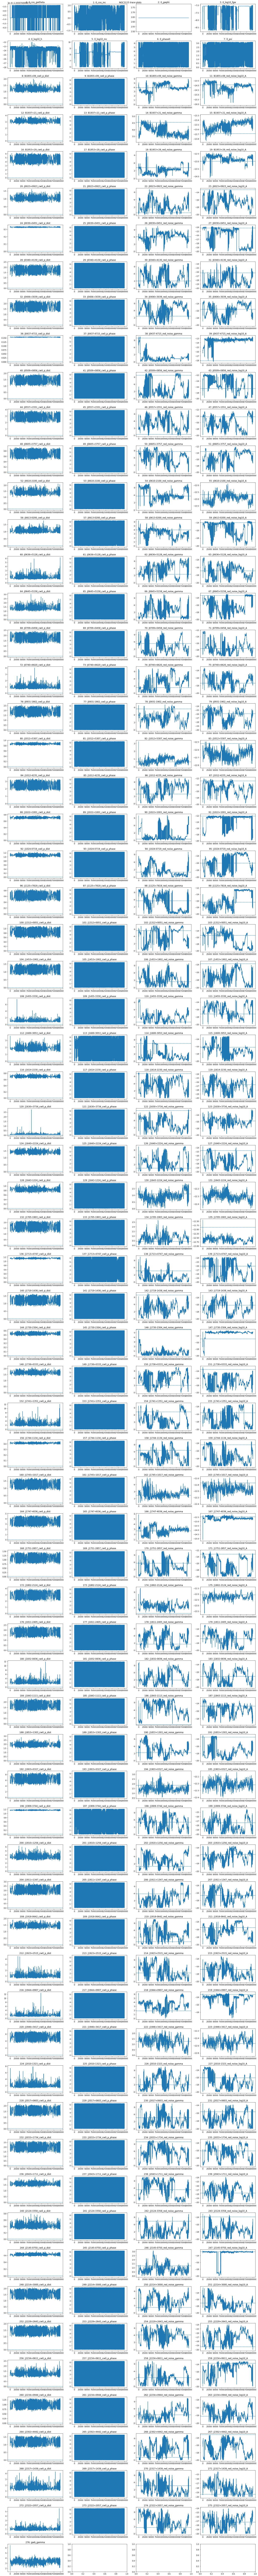

In [10]:
j=-1
row = 70
column = 4
fig, axs = plt.subplots(row, column,figsize=(20,200))#, dpi=80,squeeze=False)
fig.tight_layout(h_pad=3,w_pad=2)
#axs = plt.gca()
for i, par in enumerate(par_names[:277]):
            #plt.plot(samples_cold[0][::,i], ls='', marker='.')
    #axs[0, 0].figure(i)
    if i%4 == 0:
        j+=1
    #print(j,i)
    axs[j, i%4].plot(samples_cold[0][::5,i])#, ls='', marker='.')
    axs[j, i%4].axhline(xxx[par], ls='--')
    axs[j, i%4].set_title(str(i) + ": " + par)
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[1, i+1].plot(samples_cold[0][::,i+1], ls='', marker='.')

fig.suptitle('NGC3115 trace plots', y=1)
plt.subplots_adjust()

#display subplots 
#plt.show()
plt.savefig("/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/NGC3115/detect/NGC3115_pulsar_trace_plots2.png",dpi='figure',bbox_inches="tight")
print('done')


In [ ]:
## NOT NEEDED FROM HERE

In [ ]:
j=-1
fig, axs = plt.subplots(60, 4,figsize=(20,20))
for i, par in enumerate(par_names[:240]):
            #plt.plot(samples_cold[0][::,i], ls='', marker='.')
    #axs[0, 0].figure(i)
    if i%4 == 0:
        j+=1
    #print(j,i)
    axs[j, i%4].plot(samples_cold[0][::,i], ls='', marker='.')
    axs[j, i%4].set_title(str(i) + ": " + par)
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[1, i+1].plot(samples_cold[0][::,i+1], ls='', marker='.')
    
#for ax in axs.flat:
 #   ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axs.flat:
 #  ax.label_outer()

In [ ]:
for i, par in enumerate(par_names[8:16]):    #24#277
    plt.figure(i)
    plt.plot(samples_cold[0][::,i], ls='', marker='.')
    #plt.ylim((-7, -4)
    #ax.gca().axhline(xxx[par], ls='--')
    plt.gca().axhline(xxx[par], ls='--')
    plt.title(str(i) + ": " + par)
    #plt.plot(par)
    #plt.savefig("/scratch/na00078/QuickCW_targeted_runs/pulsar_params_check/NGC3115/new/pdf/"+ par + "_NGC3115_no_thin.pdf")


In [ ]:
for i, par in enumerate(par_names[:3]):   
    fig,ax = subplots()  
    ax.plot(i)  